## LSTM_tensorflow_tutorial [link](https://www.tensorflow.org/tutorials/structured_data/time_series)

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

/Users/tamarahuete/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
df = pd.read_csv('data/guadalupe_processed.csv')

/Users/tamarahuete/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df.head()

,Date_Time,Type,Freq,ATAvg,ATMax,ATMin,PAvg,RHAvg,RHMax,RHMin,...,Preipitacion,station,validated_range,WDcorr,WDcorr_abs,year,month,day,hour,minute
0,2013-01-11 00:00:00,NaN,5min,13.77,15.02,14.94,0.0,93.47,93.31,92.75,...,0.0,guadalupe,True,NaN,NaN,2013,1,11,0,0
1,2013-01-11 00:05:00,NaN,5min,13.70,15.02,14.94,0.0,93.19,93.31,92.75,...,0.0,guadalupe,True,NaN,NaN,2013,1,11,0,5
2,2013-01-11 00:10:00,NaN,5min,13.74,15.02,14.94,0.0,92.52,93.31,92.75,...,0.0,guadalupe,True,NaN,NaN,2013,1,11,0,10
3,2013-01-11 00:15:00,NaN,5min,13.67,15.02,14.94,0.0,92.80,93.31,92.75,...,0.0,guadalupe,True,NaN,NaN,2013,1,11,0,15
4,2013-01-11 00:20:00,NaN,5min,13.56,15.02,14.94,0.0,92.80,93.31,92.75,...,0.0,guadalupe,True,NaN,NaN,2013,1,11,0,20


In [5]:
### Subsample to get data for every hour (starting from index 0, get 12 steps)
df = df[0::12]

In [6]:
date_time = pd.to_datetime(df.pop('Date_Time'), format='%Y-%m-%d %H:%M:%S')

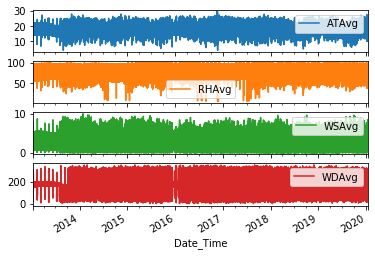

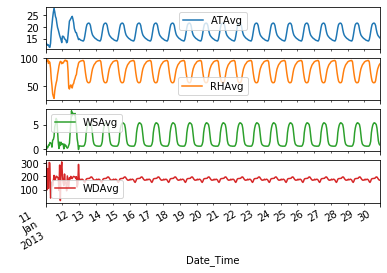

In [7]:
plot_cols = ['ATAvg', 'RHAvg', 'WSAvg','WDAvg']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

In [8]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ATAvg,61405.0,16.941256,3.385494,4.19,14.530,16.186,19.37,29.31
ATMax,61405.0,17.052636,3.248350,5.16,14.600,16.220,19.72,29.67
ATMin,61405.0,16.885732,3.159448,4.92,14.520,16.110,19.47,29.03
PAvg,61405.0,0.005251,0.043080,0.00,0.000,0.000,0.00,5.60
RHAvg,61405.0,79.721508,16.536240,5.12,65.510,83.790,94.98,100.07
RHMax,61405.0,80.435435,16.168787,5.70,65.050,85.370,95.60,100.09
RHMin,61405.0,79.101311,16.940392,5.69,62.770,83.850,95.20,100.05
WDAvg,61405.0,172.208594,59.839889,0.13,147.400,179.380,199.50,354.33
WDMax,61405.0,202.180202,49.154742,0.25,191.600,201.350,212.67,354.35
WDMin,61405.0,147.494550,52.963182,0.06,128.665,152.190,176.65,354.33


Text(0, 0.5, 'Wind Velocity [m/s]')

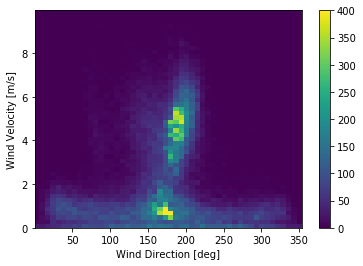

In [9]:
#### Wind Speed and Wind direction
plt.hist2d(df['WDAvg'], df['WSAvg'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

In [10]:
wv = df.pop('WSAvg')
max_wv = df.pop('WSMax')
min_wv = df.pop('WSMin')

# Convert to radians.
wd_rad = df.pop('WDAvg')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

# Calculate the min wind x and y components.
df['min Wx'] = min_wv*np.cos(wd_rad)
df['min Wy'] = min_wv*np.sin(wd_rad)

In [11]:
df.head()

,Type,Freq,ATAvg,ATMax,ATMin,PAvg,RHAvg,RHMax,RHMin,WDMax,...,month,day,hour,minute,Wx,Wy,max Wx,max Wy,min Wx,min Wy
0,NaN,5min,13.77,15.02,14.94,0.0,93.47,93.31,92.75,204.920,...,1,11,0,0,-0.318835,-0.894899,-0.355753,-0.998519,-0.151027,-0.423900
12,NaN,5min,13.06,14.77,14.70,0.0,94.82,94.13,93.80,208.140,...,1,11,1,0,0.000000,-0.000000,0.509735,-0.801667,0.230722,-0.362860
24,NaN,5min,12.63,14.54,14.48,0.0,94.79,94.76,94.43,206.125,...,1,11,2,0,-0.081534,0.462874,-0.168272,0.955293,-0.072860,0.413632
36,NaN,5min,12.29,14.41,14.34,0.0,97.16,95.17,94.85,208.140,...,1,11,3,0,-0.075347,-0.362247,-0.189387,-0.910512,-0.079420,-0.381828
48,NaN,5min,12.48,14.31,14.26,0.0,90.55,95.50,95.24,207.300,...,1,11,4,0,-0.306654,0.803469,-0.342312,0.896896,-0.146196,0.383049


(-9.574508990231022, 2.992438147043481, -6.470612299076462, 9.288897077275339)

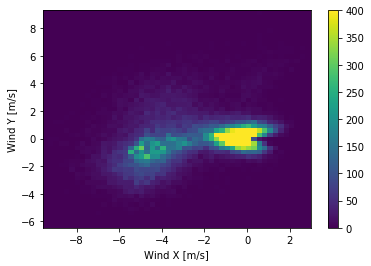

In [12]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

In [13]:
### Convert date time to seconds
timestamp_s = date_time.map(pd.Timestamp.timestamp)

In [14]:
### Fix periodicity
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

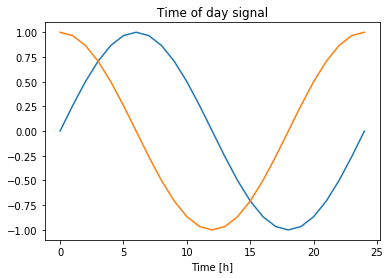

In [15]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

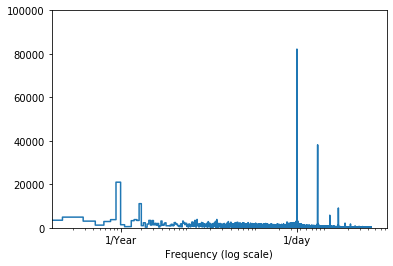

In [16]:
### Check periodicity
fft = tf.signal.rfft(df['ATAvg'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['ATAvg'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 100000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [17]:
### Skipped Precipitación
df = df[['ATAvg','ATMax','ATMin','RHAvg','RHMin','RHMax','Wx','Wy','max Wx','max Wy','min Wx', 'min Wy','Day sin','Day cos','Year sin','Year cos']]

In [18]:
df.head()

,ATAvg,ATMax,ATMin,RHAvg,RHMin,RHMax,Wx,Wy,max Wx,max Wy,min Wx,min Wy,Day sin,Day cos,Year sin,Year cos
0,13.77,15.02,14.94,93.47,92.75,93.31,-0.318835,-0.894899,-0.355753,-0.998519,-0.151027,-0.423900,-8.709422e-12,1.000000,0.180875,0.983506
12,13.06,14.77,14.70,94.82,93.80,94.13,0.000000,-0.000000,0.509735,-0.801667,0.230722,-0.362860,2.588190e-01,0.965926,0.181580,0.983376
24,12.63,14.54,14.48,94.79,94.43,94.76,-0.081534,0.462874,-0.168272,0.955293,-0.072860,0.413632,5.000000e-01,0.866025,0.182285,0.983246
36,12.29,14.41,14.34,97.16,94.85,95.17,-0.075347,-0.362247,-0.189387,-0.910512,-0.079420,-0.381828,7.071068e-01,0.707107,0.182990,0.983115
48,12.48,14.31,14.26,90.55,95.24,95.50,-0.306654,0.803469,-0.342312,0.896896,-0.146196,0.383049,8.660254e-01,0.500000,0.183694,0.982983


In [19]:
### Split data into 70%, 20%, 10% split for the training, validation, and test sets
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [20]:
num_features

16

In [21]:
### Normalize the data  ### ROOM TO MAKE TESTS (this is just an average)
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

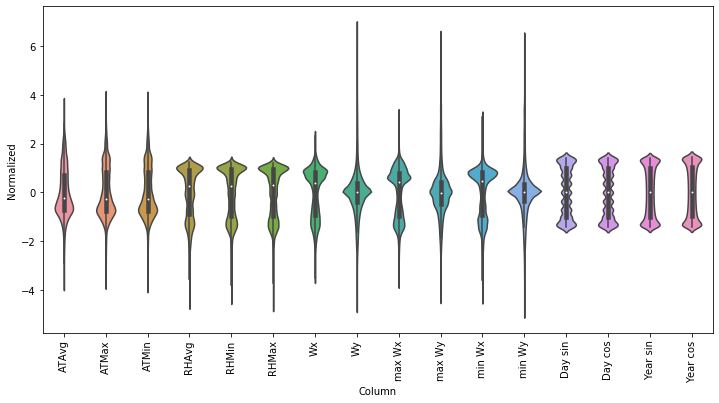

In [22]:
## Feature distributions
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [23]:
#### Data windowing
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [ ]:
## 24h inputs, 24h outputs, 1 label
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['ATAvg'])
w1

In [25]:
## 6 h input, 1 h output
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['ATAvg'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['ATAvg']

In [101]:
## 48h inputs, 24h outputs, 3 label
w3 = WindowGenerator(input_width=48, label_width=3, shift=24,
                     label_columns=['ATAvg','RHAvg'])
w3

Total window size: 72
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label indices: [69 70 71]
Label column name(s): ['ATAvg', 'RHAvg']

In [26]:
### Split window
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [27]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 16)
Inputs shape: (3, 6, 16)
labels shape: (3, 1, 1)


In [107]:
w2.total_window_size

7

In [106]:
#### How to get this split for all the dataset
train_df[:w2.total_window_size]
train_df[100:100+w2.total_window_size]

,ATAvg,ATMax,ATMin,RHAvg,RHMin,RHMax,Wx,Wy,max Wx,max Wy,min Wx,min Wy,Day sin,Day cos,Year sin,Year cos
1200,-0.801347,-0.869817,-0.857655,0.951762,0.955744,0.933868,0.610098,0.028924,0.571136,-0.008877,0.629260,0.034842,1.224710,0.707137,0.348307,1.409428
1212,-0.844326,-0.910496,-0.902814,0.973121,0.981565,0.958748,0.610499,0.052713,0.579503,0.018814,0.623622,0.054949,1.365987,0.366057,0.349279,1.409171
1224,-0.850254,-0.919883,-0.912491,0.970070,0.994921,0.973676,0.617791,0.096153,0.569113,0.073643,0.643536,0.088316,1.414174,0.000032,0.350252,1.408913
1236,-0.679819,-0.743087,-0.741532,0.827874,0.824262,0.831237,0.592009,0.205758,0.543241,0.204574,0.603085,0.187314,1.365987,-0.365993,0.351224,1.408655
1248,-0.254474,-0.290926,-0.302844,0.185552,0.142515,0.201148,0.480016,0.342064,0.432350,0.349427,0.498909,0.313395,1.224710,-0.707074,0.352196,1.408395
1260,0.307218,0.309868,0.280997,-0.393301,-0.517566,-0.456309,0.198018,0.336966,0.062902,0.359069,0.171688,0.347501,0.999970,-0.999967,0.353168,1.408135
1272,0.821485,0.874678,0.848711,-0.879697,-0.971669,-0.927788,-0.625716,0.052126,-0.737948,0.015599,-0.563014,0.057484,0.707083,-1.224711,0.354139,1.407875


In [132]:
len(train_df[0::w2.total_window_size].index.values) ### 8773 chunks

6141

In [127]:
i+w2.total_window_size

736855

In [131]:
len(train_df)

42983

In [142]:
train_df[0::w2.total_window_size].index.values

array([     0,     84,    168, ..., 515592, 515676, 515760])

In [148]:
train_df[train_df.index ==168]

,ATAvg,ATMax,ATMin,RHAvg,RHMin,RHMax,Wx,Wy,max Wx,max Wy,min Wx,min Wy,Day sin,Day cos,Year sin,Year cos
168,2.208673,1.470779,1.464809,-1.855539,-1.483943,-1.519935,-1.446515,-0.011373,-1.633013,-0.05175,-1.558559,-0.00805,-0.7071,-1.224711,0.264051,1.428864


In [187]:
#### Create sequence of arrays of all the dataset
def dataset_stack(train_df= train_df, window = w2.total_window_size):
    stack = []
    for i in range(0,len(train_df[0::window])):
        start_array = window*i
        end_array = window*i + window
        if len(train_df[start_array:end_array]) < window:
            continue
        else:
            stack.append(np.array(train_df[start_array:end_array]))
    return stack

In [188]:
stack = dataset_stack()

In [189]:
example_window = tf.stack(stack)

In [28]:
w2.example = example_inputs, example_labels

In [29]:
def plot(self, model=None, plot_col='ATAvg', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot


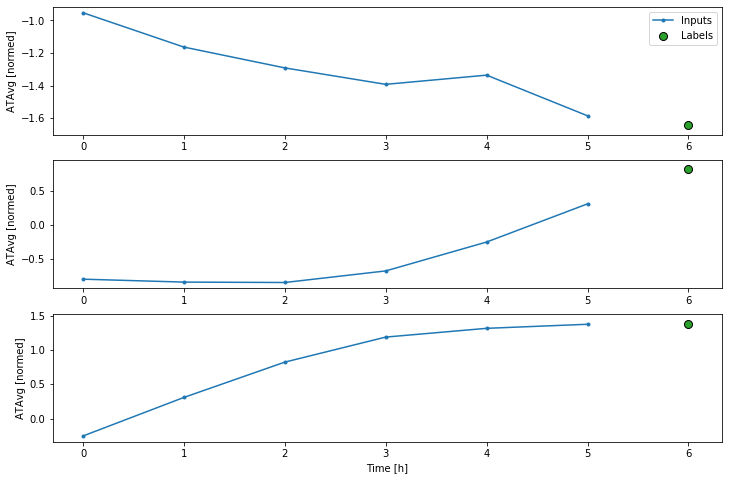

In [30]:
w2.plot()

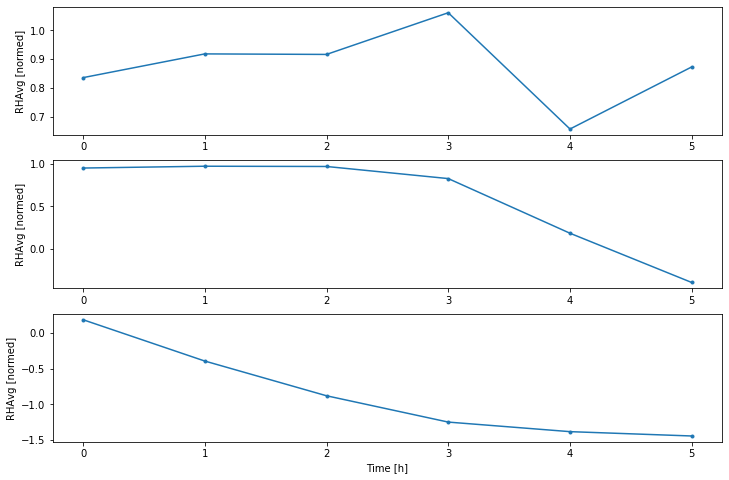

In [31]:
w2.plot(plot_col='RHAvg')

In [33]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)

  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [34]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [35]:
# Each element is an (inputs, label) pair
w2.train.element_spec

(TensorSpec(shape=(None, 6, 16), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [36]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 16)
Labels shape (batch, time, features): (32, 1, 1)


## SINGLE VARIABLE, SINGLE STEP MODEL

In [38]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['ATAvg'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['ATAvg']

In [39]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 16)
Labels shape (batch, time, features): (32, 1, 1)


### 1. Baseline

In [40]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [41]:
baseline = Baseline(label_index=column_indices['ATAvg'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

384/384 [==============================] - 1s 1ms/step - loss: 0.1377 - mean_absolute_error: 0.2611


In [44]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['ATAvg'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['ATAvg']

In [45]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 16)
Output shape: (32, 24, 1)


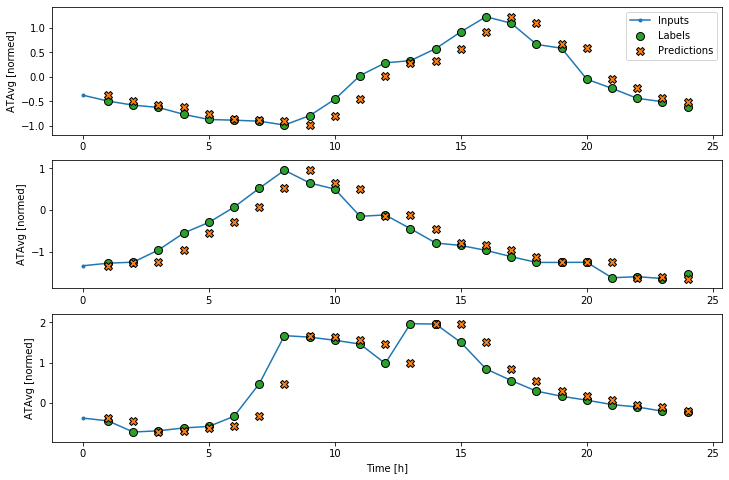

In [46]:
wide_window.plot(baseline)

## 2. Linear Model

In [47]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [48]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 16)
Output shape: (32, 1, 1)


In [49]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [50]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
1344/1344 [==============================] - 3s 2ms/step - loss: 0.3001 - mean_absolute_error: 0.3984 - val_loss: 0.1427 - val_mean_absolute_error: 0.2912
Epoch 2/20
1344/1344 [==============================] - 2s 2ms/step - loss: 0.1450 - mean_absolute_error: 0.2733 - val_loss: 0.0934 - val_mean_absolute_error: 0.2310s: 0.1482 - mean_absolute_error:
Epoch 3/20
1344/1344 [==============================] - 3s 2ms/step - loss: 0.1232 - mean_absolute_error: 0.2486 - val_loss: 0.0859 - val_mean_absolute_error: 0.2225
Epoch 4/20
1344/1344 [==============================] - 2s 1ms/step - loss: 0.1186 - mean_absolute_error: 0.2428 - val_loss: 0.0854 - val_mean_absolute_error: 0.2220
Epoch 5/20
1344/1344 [==============================] - 2s 1ms/step - loss: 0.1172 - mean_absolute_error: 0.2409 - val_loss: 0.0854 - val_mean_absolute_error: 0.2219
Epoch 6/20
1344/1344 [==============================] - 2s 1ms/step - loss: 0.1165 - mean_absolute_error: 0.2397 - val_loss: 0.0857 - val_

In [51]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 16)
Output shape: (32, 24, 1)


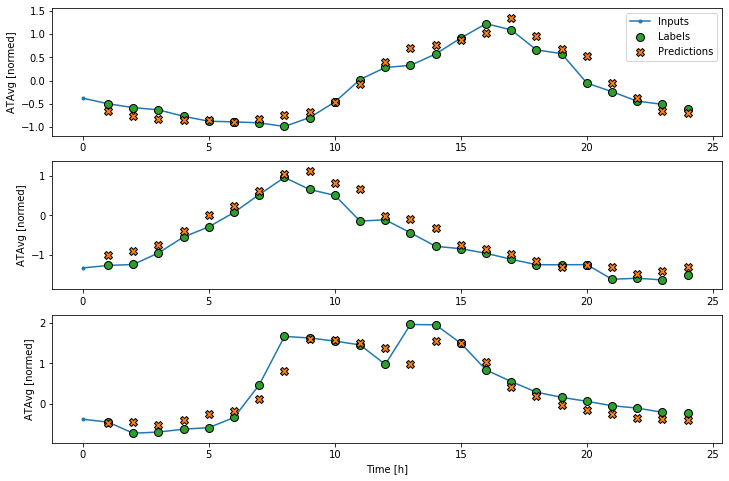

In [55]:
wide_window.plot(linear)

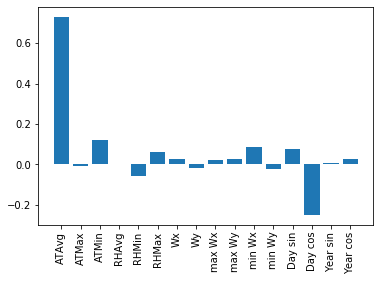

In [53]:
## Weights of each input
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

### 3. Dense

In [56]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
1344/1344 [==============================] - 3s 2ms/step - loss: 0.1158 - mean_absolute_error: 0.2277 - val_loss: 0.0652 - val_mean_absolute_error: 0.1795
Epoch 2/20
1344/1344 [==============================] - 2s 2ms/step - loss: 0.0993 - mean_absolute_error: 0.2079 - val_loss: 0.0669 - val_mean_absolute_error: 0.1877
Epoch 3/20
1344/1344 [==============================] - 2s 2ms/step - loss: 0.0968 - mean_absolute_error: 0.2040 - val_loss: 0.0600 - val_mean_absolute_error: 0.1732
Epoch 4/20
1344/1344 [==============================] - 2s 2ms/step - loss: 0.0957 - mean_absolute_error: 0.2020 - val_loss: 0.0641 - val_mean_absolute_error: 0.1806
Epoch 5/20
1344/1344 [==============================] - 2s 2ms/step - loss: 0.0945 - mean_absolute_error: 0.2003 - val_loss: 0.0599 - val_mean_absolute_error: 0.1709
Epoch 6/20
1344/1344 [==============================] - 2s 2ms/step - loss: 0.0942 - mean_absolute_error: 0.1996 - val_loss: 0.0590 - val_mean_absolute_error: 0.1735
Epoc

In [58]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['ATAvg'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['ATAvg']

Text(0.5, 1.0, 'Given 3h as input, predict 1h into the future.')

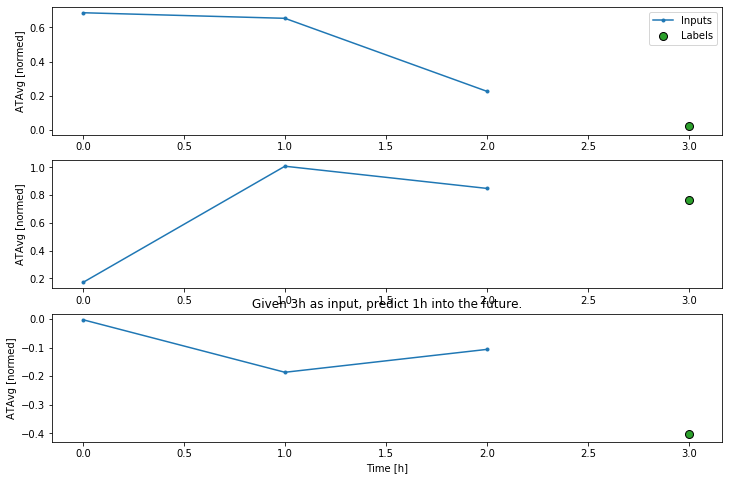

In [59]:
conv_window.plot()
plt.title("Given 3h as input, predict 1h into the future.")

### 4. Multi-step Dense

In [60]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [61]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 16)
Output shape: (32, 1, 1)


In [62]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

384/384 [==============================] - 1s 1ms/step - loss: 0.0620 - mean_absolute_error: 0.1794


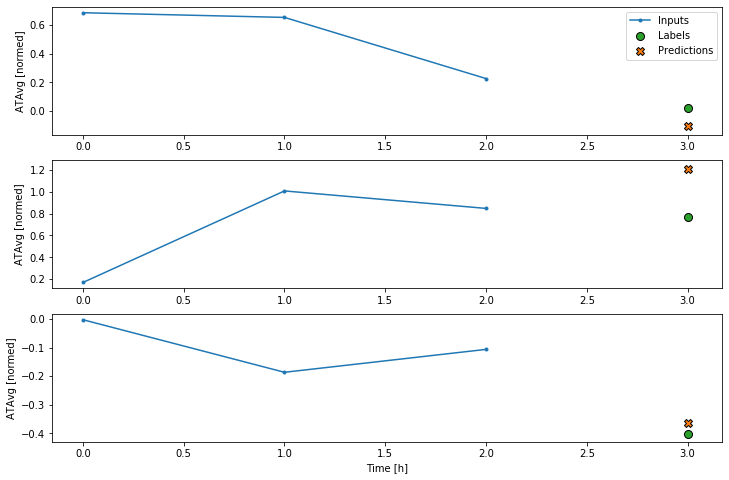

In [63]:
conv_window.plot(multi_step_dense)

In [64]:
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 24, 16)

ValueError:Input 0 of layer dense_4 is incompatible with the layer: expected axis -1 of input shape to have value 48 but received input with shape (32, 384)


### 5. CNN

In [65]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [66]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 16)
Output shape: (32, 1, 1)


In [67]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

384/384 [==============================] - 1s 1ms/step - loss: 0.0630 - mean_absolute_error: 0.1785


In [68]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 16)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


In [70]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['ATAvg'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['ATAvg']

In [71]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 16)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


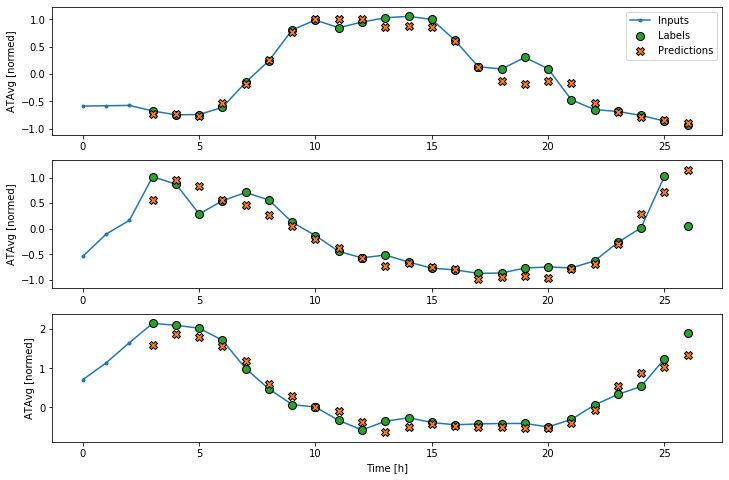

In [72]:
wide_conv_window.plot(conv_model)

### 6. RNN

In [73]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [74]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 16)
Output shape: (32, 24, 1)


In [75]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

384/384 [==============================] - 1s 2ms/step - loss: 0.0612 - mean_absolute_error: 0.1748


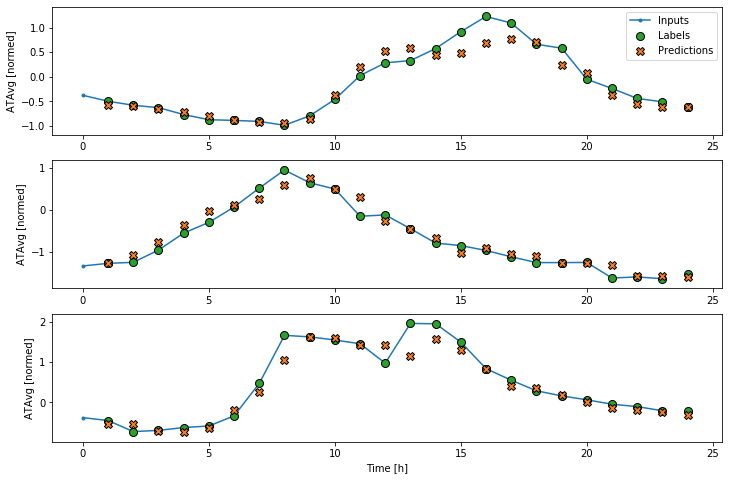

In [76]:
wide_window.plot(lstm_model)

### Evaluate Performance

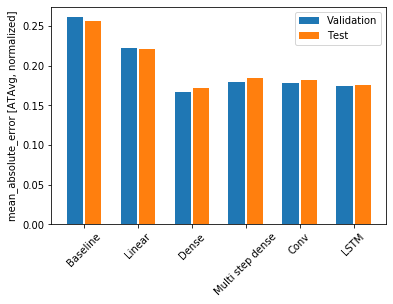

In [77]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [ATAvg, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [78]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.2559
Linear      : 0.2205
Dense       : 0.1716
Multi step dense: 0.1843
Conv        : 0.1819
LSTM        : 0.1760


## MULTI-VARIATE, SINGLE STEP MODEL

In [79]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 16)
Labels shape (batch, time, features): (32, 24, 16)


### 1. Baseline

In [80]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

In [81]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

384/384 [==============================] - 1s 1ms/step - loss: 0.3699 - mean_absolute_error: 0.3574


### 2. Dense

In [82]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [ ]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

### 3. RNN

In [83]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

384/384 [==============================] - 1s 3ms/step - loss: 0.2193 - mean_absolute_error: 0.2579

CPU times: user 4min 45s, sys: 1min 3s, total: 5min 49s
Wall time: 2min 13s


### 4. Residual connections

In [ ]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each timestep is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [ ]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small
        # So initialize the output layer with zeros
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

In [ ]:
### Performance

In [ ]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [ ]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

## MULTI-VARIATE, MULTI-STEP MODEL

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

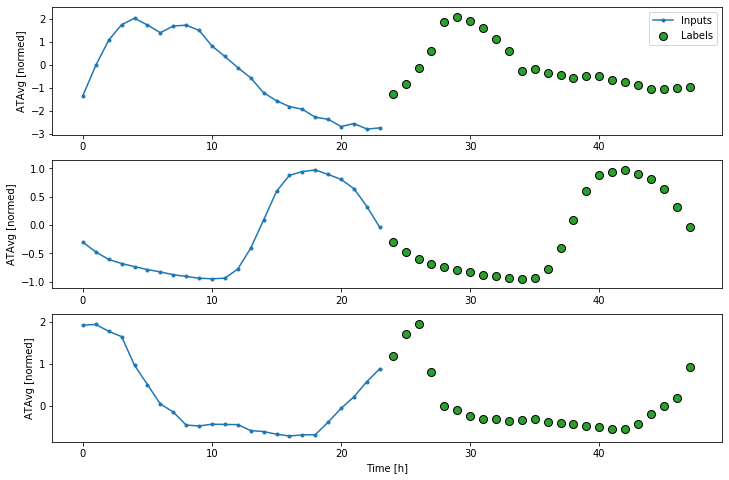

In [84]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

383/383 [==============================] - ETA: 0s - loss: 1.7230 - mean_absolute_error: 0.949 - 1s 1ms/step - loss: 1.7232 - mean_absolute_error: 0.9494


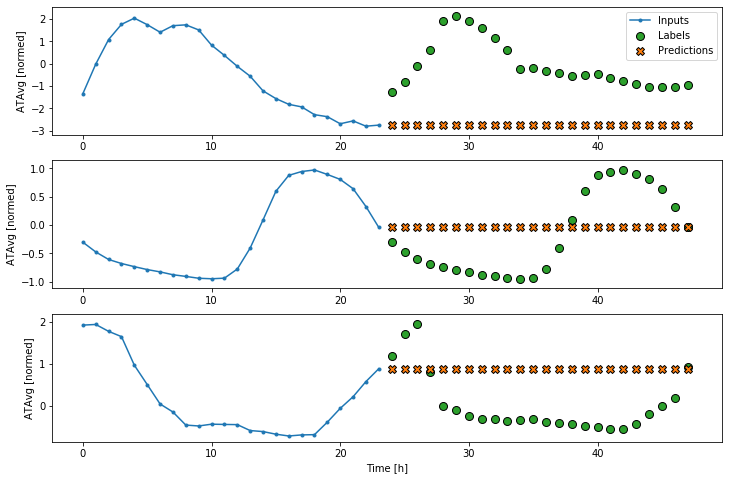

In [85]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

383/383 [==============================] - 1s 1ms/step - loss: 0.5330 - mean_absolute_error: 0.4163


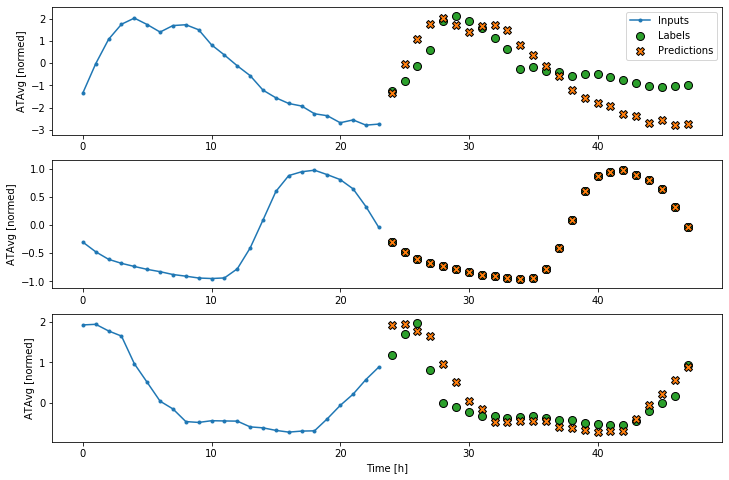

In [86]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

### Single-Shot

383/383 [==============================] - 1s 1ms/step - loss: 0.3561 - mean_absolute_error: 0.3662


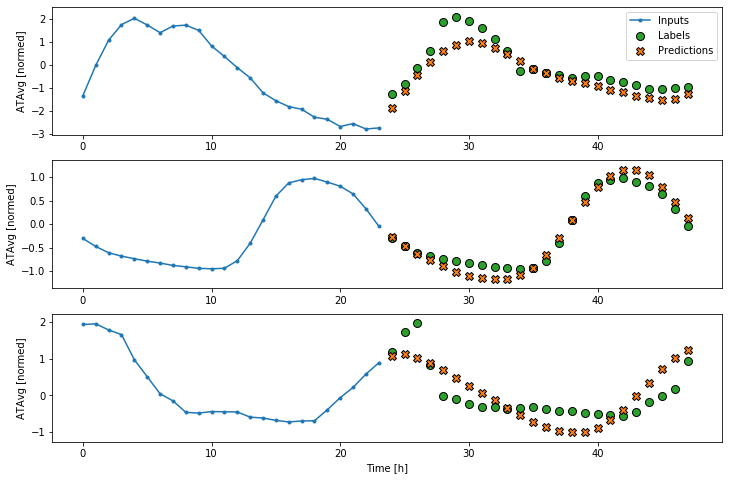

In [87]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

### Dense

383/383 [==============================] - 1s 2ms/step - loss: 0.3099 - mean_absolute_error: 0.3234


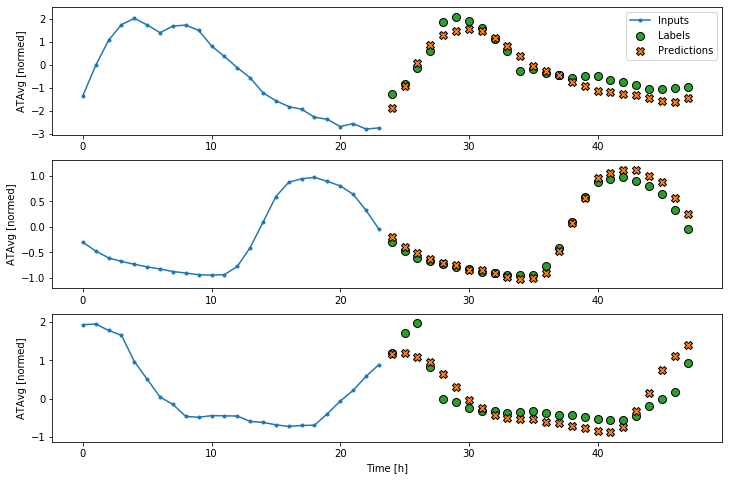

In [88]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

## CNN

383/383 [==============================] - 1s 1ms/step - loss: 0.3131 - mean_absolute_error: 0.3281


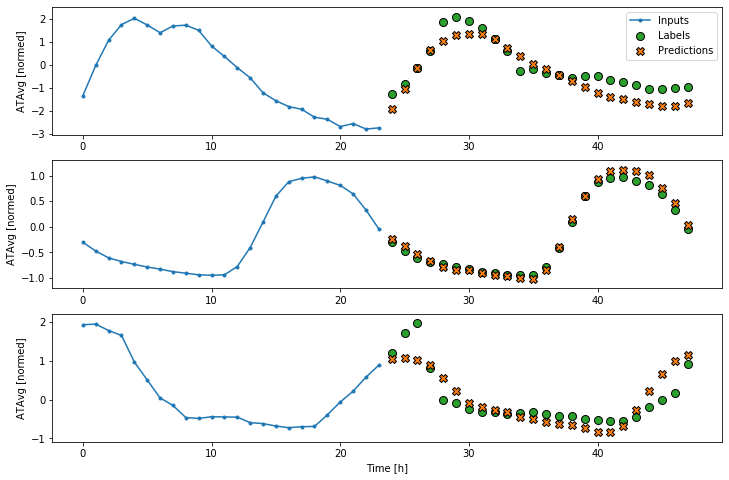

In [89]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

## RNN

383/383 [==============================] - 1s 3ms/step - loss: 0.3024 - mean_absolute_error: 0.3278


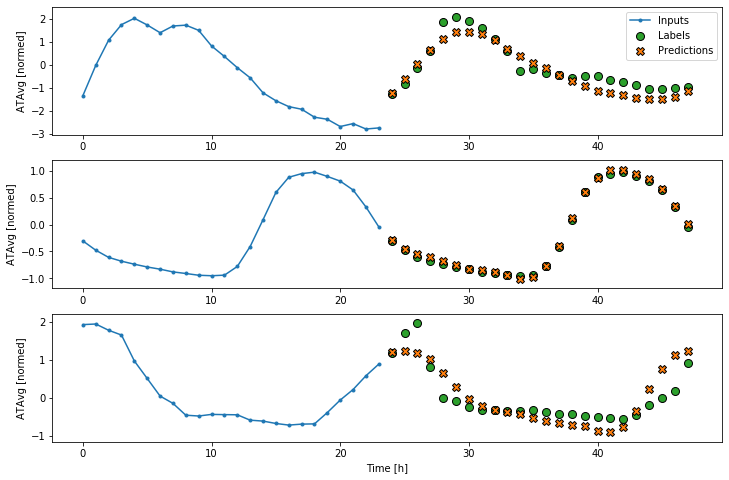

In [90]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

### Autoregressive model RNN

In [91]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [92]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [93]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [94]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 16])

In [95]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the lstm state
  prediction, state = self.warmup(inputs)

  # Insert the first prediction
  predictions.append(prediction)

  # Run the rest of the prediction steps
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [96]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 16)


383/383 [==============================] - 2s 4ms/step - loss: 0.3011 - mean_absolute_error: 0.3266


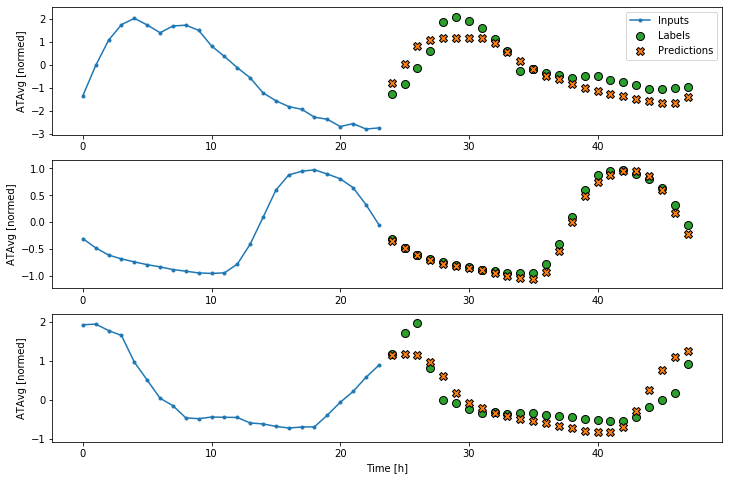

In [97]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

### Performance

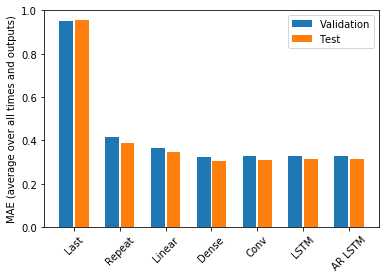

In [99]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [100]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.9554
Repeat  : 0.3896
Linear  : 0.3487
Dense   : 0.3072
Conv    : 0.3117
LSTM    : 0.3135
AR LSTM : 0.3127
